<a href="https://colab.research.google.com/github/mryfrjzd/Youtube-Code-Repository/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from collections import deque
from tensorflow import gather_nd
from tensorflow.keras.losses import mean_squared_error
import matplotlib.pyplot as plt
import time
import os
import gym
from datetime import datetime

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:

class DeepQLearning:

    ###########################################################################
    #   START - __init__ function
    ###########################################################################
    # INPUTS:
    # env - Cart Pole environment
    # gamma - discount rate
    # epsilon - parameter for epsilon-greedy approach
    # numberIterations - total number of simulation Iterations


    def __init__(self, env, gamma, epsilon_init, alpha_init, numberIterations, learning_rate, replayBufferSize, batchReplayBufferSize, updateTargetNetworkPeriod, epochThreshold):


        self.env=env
        self.gamma=gamma
        self.epsilon=epsilon
        self.numberIterations=numberIterations
        self.alpha = alpha


        self.learning_rate = learning_rate
        # state dimension
        self.stateDimension=4
        # action dimension
        self.actionDimension=2
        # this is the maximum size of the replay buffer
        self.replayBufferSize=replayBufferSize
        # this is the size of the training batch that is randomly sampled from the replay buffer
        self.batchReplayBufferSize=batchReplayBufferSize
        self.epochThreshold=epochThreshold

        # number of training Iterations it takes to update the target network parameters
        # that is, every updateTargetNetworkPeriod we update the target network parameters
        self.updateTargetNetworkPeriod=updateTargetNetworkPeriod

        # this is the counter for updating the target network
        # if this counter exceeds (updateTargetNetworkPeriod-1) we update the network
        # parameters and reset the counter to zero, this process is repeated until the end of the training process
        self.counterUpdateTargetNetwork=0

        # this sum is used to store the sum of rewards obtained during each training episode

        self.sumMeanSquareError=[]
        self.sumQ_Val=[]
        self.sumRewardsEpisode=[]

        # replay buffer
        self.replayBuffer=deque(maxlen=self.replayBufferSize)

        # this list is used in the cost function to select certain entries of the
        # predicted and true sample matrices in order to form the loss
        # self.actionsAppend = []
        self.actionsAppend = [[] for _ in range(self.batchReplayBufferSize)]




        # this is the main network
        # create network
        self.mainNetwork=self.createNetwork()

        # this is the target network
        # create network
        self.targetNetwork=self.createNetwork()

        # copy the initial weights to targetNetwork
        self.targetNetwork.set_weights(self.mainNetwork.get_weights())

    def my_loss_fn(self,y_true, y_pred):
        s1,s2=y_true.shape
        #print(s1,s2)
        # this matrix defines indices of a set of entries that we want to
        # extract from y_true and y_pred
        s2=self.actionDimension
        s1=self.batchReplayBufferSize
        indices=np.zeros(shape=(s1,s2))
        # indices = np.empty((s1, s2), dtype=object)
        indices[:,0]=np.arange(s1)
        # for i in range(s1):
        #     indices[i, 1] = self.actionsAppend[i]
        indices[:,1]=self.actionsAppend
        # gather_nd and mean_squared_error are TensorFlow functions
        index_for_gather = indices[:, 0].astype(int)  # Extract and convert the first column to integer type

        loss = mean_squared_error(gather_nd(y_true,indices=indices.astype(int)), gather_nd(y_pred,indices=indices.astype(int)))
        print(loss)
        print("y_true", y_true)
        print("y_pred", y_pred)
        # loss = tf.reduce_mean(tf.square(y_true - y_pred))
        print("loss", loss)
        return loss

    def createNetwork(self):
        model=Sequential()
        model.add(Dense(128,input_dim=self.stateDimension,activation='relu'))
        model.add(Dense(56,activation='relu'))
        model.add(Dense(self.actionDimension,activation='linear'))

        model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate),
                      metrics=['accuracy'])
        return model

    def trainingIterations(self):
        for Iteration in range(self.numberIterations):
            print(f'Iteration: {Iteration}')
            rewardsEpisode=[]
            meanSquareError=[]
            sumQ_Val_ite=[]
            currentState = self.env.reset()
            terminalState=False
            epoch=0
            while ((not terminalState) and (epoch < self.epochThreshold)):
                epoch=epoch+1
                print("epoch",epoch)
                action = self.selectAction(currentState,Iteration)
                (nextState, reward, terminalState,_) = self.env.step(action)
                rewardsEpisode.append(reward)
                self.replayBuffer.append((currentState,action,reward,nextState,terminalState))
                mse, sumQ=self.trainNetwork(Iteration)
                meanSquareError.append(mse)
                sumQ_Val_ite.append(sumQ)
                currentState=nextState
            self.sumMeanSquareError.append(np.sum(meanSquareError))
            self.sumQ_Val.append(np.sum(sumQ_Val_ite))
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))
        # return
        # plt.figure(figsize=(10, 5))
        # plt.plot(self.sumMeanSquareError, label='Total Reward per Episode')
        # plt.xlabel('Iteration')
        # plt.ylabel('Mean Squared Error')
        # plt.title('Convergence of Deep Q-Learning Algorithm')
        # plt.legend()
        # plt.show()

    def selectAction(self,state,Iteration):
        import numpy as np
        randomNumber=np.random.random()
        if randomNumber < self.epsilon[0,Iteration]:
            return np.random.choice(self.actionDimension)
        else:
            Qvalues=self.mainNetwork.predict(state.reshape(1,4))
            return np.random.choice(np.where(Qvalues[0,:]==np.max(Qvalues[0,:]))[0])


    def trainNetwork(self, Iteration):
        if (len(self.replayBuffer)>self.batchReplayBufferSize):
            randomSampleBatch=random.sample(self.replayBuffer, self.batchReplayBufferSize)
            currentStateBatch=np.zeros(shape=(self.batchReplayBufferSize,4))
            nextStateBatch=np.zeros(shape=(self.batchReplayBufferSize,4))
            for index,tupleS in enumerate(randomSampleBatch):
                currentStateBatch[index,:]=tupleS[0]
                nextStateBatch[index,:]=tupleS[3]
            QnextStateTargetNetwork=self.targetNetwork.predict(nextStateBatch)
            QcurrentStateMainNetwork=self.mainNetwork.predict(currentStateBatch)
            inputNetwork=currentStateBatch
            outputNetwork=np.zeros(shape=(self.batchReplayBufferSize,2))
            self.actionsAppend=[]
            for index,(currentState,action,reward,nextState,terminated) in enumerate(randomSampleBatch):
                if terminated:
                    y=reward
                else:
                    y=reward+self.gamma*np.max(QnextStateTargetNetwork[index])
                # print("self.actionsAppend.append(action)",self.actionsAppend)
                self.actionsAppend.append(action)
                # print("self.actionsAppend.append(action)", self.actionsAppend)
                outputNetwork[index]=QcurrentStateMainNetwork[index]
                # print("outputNetwork[index]=QcurrentStateMainNetwork[index]", outputNetwork)
                outputNetwork[index,action]=(self.alpha[0,Iteration] * y )+ ((1 - self.alpha[0,Iteration]) * outputNetwork[index,action])
                # print("outputNetwork[index,action]", outputNetwork)
                # print("-------")
            Q = self.mainNetwork.predict(currentStateBatch)
            self.mainNetwork.fit(inputNetwork,outputNetwork,batch_size = self.batchReplayBufferSize, verbose=0,epochs=100)
            self.counterUpdateTargetNetwork+=1
            if (self.counterUpdateTargetNetwork>(self.updateTargetNetworkPeriod-1)):
                self.targetNetwork.set_weights(self.mainNetwork.get_weights())
                self.counterUpdateTargetNetwork=0
            Q_ = self.mainNetwork.predict(currentStateBatch)
            mse = tf.reduce_mean(tf.square(Q - Q_))
            sumQ_=np.sum(Q_)
            return mse, sumQ_
        else:
            return 0, 0


In [5]:




def epsilon_decay(epsilon_init, numberIterations, fig):
    if epsilon_init == 0.9 and numberIterations == 100000:
        ee = 5000000000000 + 2
    # elif epsilon_init == 0.9 and numberIterations == 1000000:
    #     ee = 5000000000000000 * 2
    elif epsilon_init == 0.9 and numberIterations == 1000000:
        ee = 500000000000000 * 2
    elif epsilon_init == 0.9 and numberIterations == 10000:
        ee = 500000000
    elif epsilon_init == 0.9 and numberIterations == 20000:
        ee = 5000000000 * 2
    elif epsilon_init == 0.9 and numberIterations == 1000:
        ee = 500000 * 2
    elif epsilon_init == 0.9 and numberIterations == 100:
        ee = 5000
    else:
        ee = 500
    epsilon = np.zeros((1, numberIterations))
    epsilon[0, 0] = epsilon_init
    epsilon[0, 1] = epsilon_init
    for ite in range(1, int(np.ceil(numberIterations)), 1):
        uz = ite ** 2 / (ee + ite)
        epsilon[0, ite] = epsilon[0, ite - 1] / (1 + uz)
        last_ite = ite
    if fig > 0 :
        fig=fig+1
        plt.figure(fig)
        plt.plot(epsilon[0, :])
        plt.xlabel('Iterations')
        plt.ylabel('epsilon')
        plt.title('epsilon decay')
        # file_name=
        file_name = f"epsilon_decay_{fig}.png"
        figure_filename = os.path.join(folder_name, file_name)
        plt.savefig(figure_filename)
        # plt.show()
        plt.ion()  # plt.show()
        plt.pause(2)
        plt.close()
    return epsilon


def alpha_decay(alpha_init, numberIterations, fig):
    if alpha_init == 0.9 and numberIterations == 100000:
        ee = 500000000000000
    # elif epsilon_init == 0.9 and numberIterations == 1000000:
    #     ee = 5000000000000000 * 2
    elif alpha_init == 0.9 and numberIterations == 1000000:
        ee = 50000000000000000 * 2
    elif alpha_init == 0.9 and numberIterations == 10000:
        ee = 50000000000
    elif alpha_init == 0.9 and numberIterations == 20000:
        ee = 500000000000 * 2
    elif alpha_init == 0.9 and numberIterations == 1000:
        ee = 50000000* 2
    elif alpha_init == 0.9 and numberIterations == 100:
        ee = 50000 * 5
    else:
        ee = 5000 *5

    alpha = np.zeros((1, numberIterations))
    alpha[0, 0] = alpha_init
    alpha[0, 1] = alpha_init
    for ite in range(1, int(np.ceil(numberIterations)), 1):
        uz = ite ** 2 / (ee + ite)
        alpha[0, ite] = alpha[0, ite - 1] / (1 + uz)
        last_ite = ite
    if fig > 0 :
        fig=fig+1
        plt.figure(fig)
        plt.plot(alpha[0, :])
        plt.xlabel('Iterations')
        plt.ylabel('alpha')
        plt.title('alpha decay')
        # file_name=
        file_name = f"alpha_decay{fig}.png"
        figure_filename = os.path.join(folder_name, file_name)
        plt.savefig(figure_filename)
        # plt.show()
        plt.ion()  # plt.show()
        plt.pause(2)
        plt.close()
    return alpha


In [6]:
gamma=0.9
epsilon_init=0.9
alpha_init=0.9
numberIterations=1000
numberIterations
learning_rate=0.1
replayBufferSize=300
batchReplayBufferSize=100
updateTargetNetworkPeriod=10
epochThreshold=10


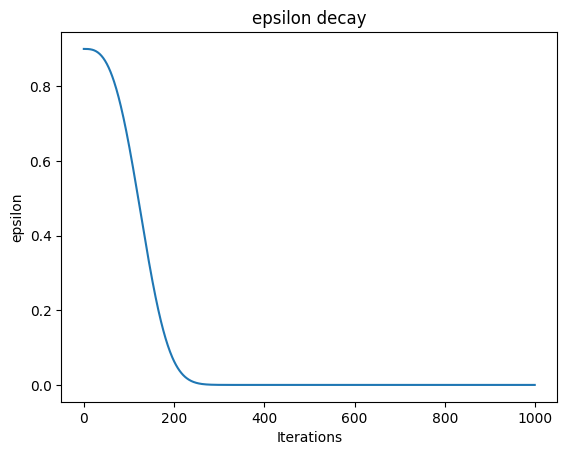

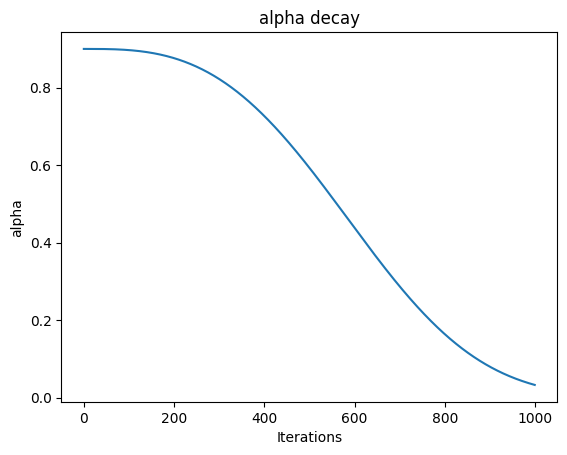

(1, 1000)


In [7]:

fig = 1
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M")
folder_name = f"DQN_Run_{timestamp}"
# file_name = f"shortest_path_{fig}.png"
# figure_filename = os.path.join(folder_name, file_name)

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

epsilon=epsilon_decay(epsilon_init, numberIterations, fig)

fig=fig+1
alpha=alpha_decay(alpha_init, numberIterations, fig)
print(alpha.shape)

In [8]:

env=gym.make('CartPole-v1')
LearningQDeep=DeepQLearning(env, gamma, epsilon_init, alpha_init, numberIterations, learning_rate, replayBufferSize, batchReplayBufferSize, updateTargetNetworkPeriod, epochThreshold )
LearningQDeep.trainingIterations()
LearningQDeep.sumRewardsEpisode

LearningQDeep.mainNetwork.summary()
LearningQDeep.mainNetwork.save("trained_model_temp.h5")




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 2ms/step
epoch 4
4/4 [==============================] - 0s 2ms/step
epoch 5
4/4 [==============================] - 0s 2ms/step
epoch 6
4/4 [==============================] - 0s 2ms/step
epoch 7
4/4 [==============================] - 0s 2ms/step
epoch 8
4/4 [==============================] - 0s 2ms/step
epoch 9
4/4 [==============================] - 0s 2ms/step
epoch 10
4/4 [==============================] - 0s 2ms/step
Iteration: 919
epoch 1
4/4 [==============================] - 0s 2ms/step
epoch 2
4/4 [==============================] - 0s 2ms/step
epoch 3
4/4 [==============================] - 0s 2ms/step
epoch 4
4/4 [==============================] - 0s 2ms/step
epoch 5
4/4 [==============================] - 0s 2ms/step
epoch 6
4/4 [==============================] - 0s 2ms/step
epoch 7
4/4 [==============================] - 0s 2ms/step
epoch 8
4/4 [==============================] - 0s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


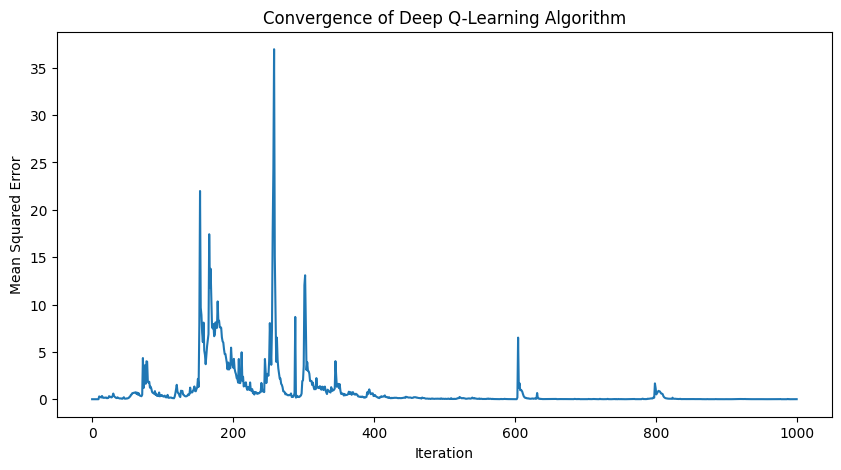

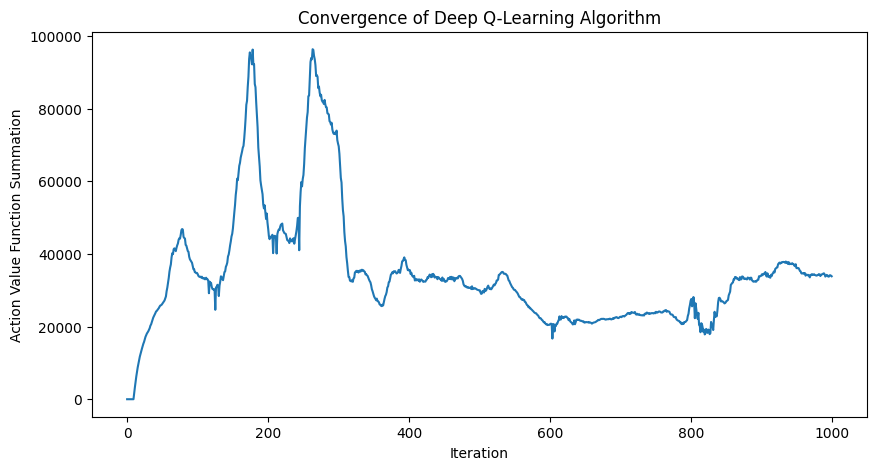

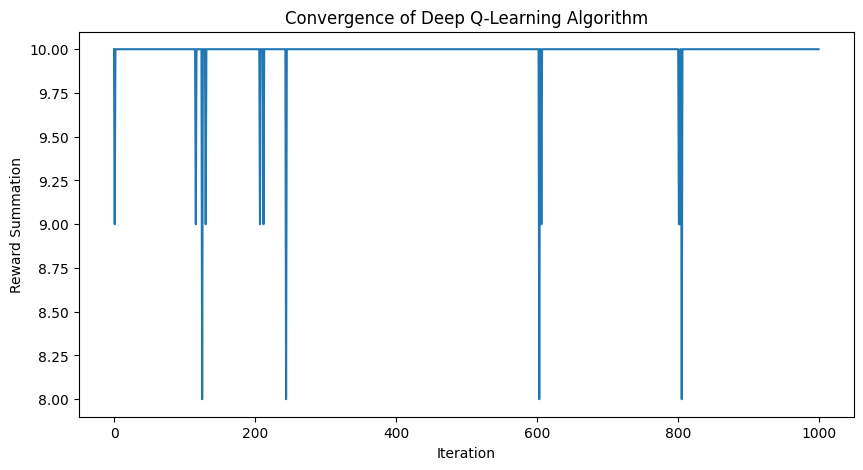

In [9]:
# self.sumMeanSquareError.append(np.sum(meanSquareError))
# self.sumQ_Val.append(np.sum(sumQ_Val_ite))
# self.sumRewardsEpisode.append(np.sum(rewardsEpisode))

plt.figure(figsize=(10, 5))
plt.plot(LearningQDeep.sumMeanSquareError, label='Total Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Convergence of Deep Q-Learning Algorithm')
# plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(LearningQDeep.sumQ_Val, label='Total Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Action Value Function Summation')
plt.title('Convergence of Deep Q-Learning Algorithm')
# plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(LearningQDeep.sumRewardsEpisode, label='Total Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Reward Summation')
plt.title('Convergence of Deep Q-Learning Algorithm')
# plt.legend()
plt.show()